In [20]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def p_simple():
    mean = torch.zeros(2)              # shape (dim,)
    cov = torch.eye(2)                 # dim x dim covariance
    return D.MultivariateNormal(mean, cov)

def p_data(device, n_samples=1000):
    mean = torch.tensor([10.0, 0.0])
    cov = torch.eye(2)
    dist = D.MultivariateNormal(mean, cov)
    return dist.sample((n_samples,)).to(device)

def build_mlp(dims, activation=torch.nn.SiLU):
    mlp = []
    for idx in range(len(dims) - 1):
        mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
        if idx < len(dims) - 2:
            mlp.append(activation())
    return torch.nn.Sequential(*mlp)

def make_mlp_vector_field(dim, hiddens):
    net = build_mlp([dim + 1] + hiddens + [dim])

    def vector_field(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        xt = torch.cat([x, t], dim=-1)
        return net(xt)

    return vector_field

def conditional_path(z, t):
    x0 = p_simple().sample((z.shape[0],))
    return (1-t)*x0 + t*z

def conditional_vector_field(x, z, t):
    return (z - x) / (1 - t)

def train(model, num_epochs, device, lr = 1e-3, batch_size=1000):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        opt.zero_grad()
        loss = get_train_loss(device, model, batch_size)
        loss.backward()
        opt.step()
        pbar.set_description(f'Epoch {epoch}, loss: {loss.item()}')

    model.eval()

def get_train_loss(device, model, batch_size):
    z = p_data(device, batch_size) # (bs, dim)
    t = torch.rand(batch_size,1).to(z) # (bs, 1)
    x = conditional_path(z, t) # (bs, dim)

    ut_theta = model(x,t) # (bs, dim)
    ut_ref = conditional_vector_field(x,z,t) # (bs, dim)
    error = torch.sum(torch.square(ut_theta - ut_ref), dim=-1) # (bs,)
    return torch.mean(error)


In [112]:
linear_flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])
train(linear_flow_model, num_epochs=5000, device=device, lr=1e-3, batch_size=1000)

Epoch 4999, loss: 3.0579030513763428: 100%|██████████| 5000/5000 [00:32<00:00, 152.19it/s]



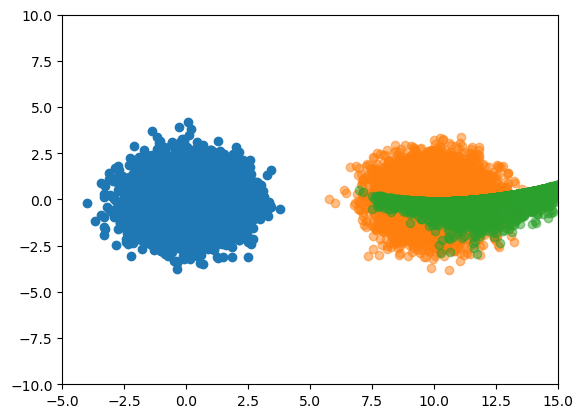

In [113]:
linear_flow_model.eval()

samples = p_simple().sample((10000,))
plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu())
data_samples = p_data(device).cpu()
plt.scatter(data_samples[:, 0], data_samples[:, 1], alpha=0.5)
network_samples = linear_flow_model(samples.to(device), torch.ones((samples.shape[0],1)).to(device)).cpu().detach().numpy()
plt.scatter(network_samples[:, 0], network_samples[:, 1], alpha=0.5)
plt.xlim(-5, 15)
plt.ylim(-10, 10)
plt.show()